Dynamical system given by:

$$dX_t = b(t,X_t,\alpha_t)dt + \sigma(t,X_t,\alpha_t)dW_t, \quad t \in [0,T].$$

Cost functional given by:

$$J[\alpha] = E\big[ \int_0^T f(t,X_t,\alpha_t)dt + g(X_T) \big].$$

Consider specific case: 

$b(t,x,\alpha) =  \alpha$, $\sigma(t,x,\alpha) = ax$, $f(t,x,\alpha) = c \alpha^2 + e x^2$, $g(X) = \epsilon x^2$, 

where $ a = 1$, $ c = 1$, $e=0$,  $\epsilon= \frac{1}{2}$. 

Take the initial condition $X_0 = 1$.


$$dX_t = \alpha_t dt +  X_t dW_t, \quad t \in [0,T],$$

$$J[\alpha] = E\big[ \int_0^T  \alpha_t^2 dt + \frac{1}{2} X_T^2 \big].$$


In [1]:
import math
import torch
torch.log(torch.Tensor([1,2,3]))

tensor([0.0000, 0.6931, 1.0986])

In [2]:
import numpy as np

a = 1
c = 1
e = 0
eps = .5

def b(t,X,α):
    return α

def σ(t,X,α):
    return a*X


def f(t,X,α):
    return c*α**2 + e*X**2

def g(X):
    return eps*X**2

First, let us build our neural network. We will need the pytorch library so we will import the following:

In [3]:
import torch
from torch import nn

The class of functions that will be used as controls $\alpha$:

In [4]:
class Model(nn.Module):
    #Standard NN
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential( 
            nn.Linear(2,64),   #2 x 64 operation. i.e. maps n x 2 to n x 64 via: x maps to xA + b
            nn.Sigmoid(),      #activation 
            nn.Linear(64, 64), #maps n x 64 to n x 64
            nn.Sigmoid(),      #activation
            nn.Linear(64, 1),  #maps n x 64 to n x 1
            )
    def forward(self,z):
        return self.net(z)

Instantiate $\alpha_{NN}$

In [5]:
α_NN = Model() #instantiates a NN with architecture given in model.

Simulate the SDE:

In [6]:
import numpy as np #always a good library to have

T = 1 
N_steps = 100 #Number of time discretizations of ODE.
dt = T/N_steps #size of dt for euler scheme

N_sim = 2**10 #Number of random paths to generate

def simulate_SDE(α_NN):
    dW_t = torch.randn(N_sim,N_steps,1)*np.sqrt(dt)

    X = np.empty(N_steps+1,'O') #preallocating X. 'O' is so that it stores objects. It will be a numpy array of torch tensors.
    α = np.empty(N_steps,'O')

    running_cost_step = np.empty(N_steps,'O')

    X[0] = torch.ones((N_sim,1)) #initial condition for X.

    for i in range(0,N_steps):
        t = i*dt*torch.ones((N_sim,1)) #because solving SDE for each path simulataneously, t must be size N_sim x 1
                                       #since t must be concatenated with x to be inputted into the NN. 
            
        tx = torch.cat((t,X[i]),1) #this is (t_i,X_i) but as a torch tensor. So it can be inputted into α_NN

        α[i] = α_NN(tx) #mapping the current (t_i, X(t_i)) to an approximate ̂α_i via the NN control
        X[i+1] = X[i] + b(t,X[i],α[i])*dt + σ(t,X[i],α[i])*dW_t[:,i,:] #Euler step for SDE

        running_cost_step[i] = f(t,X[i],α[i])*dt

    terminal_cost = g(X[N_steps])

    J = (sum(running_cost_step) + terminal_cost).sum()/N_sim
    
    return X,α,J



In [7]:
opt = torch.optim.Adam(α_NN.parameters(), lr=.001)

N_epoch = 1000

for n in range(0,N_epoch):
    
    _,_,J = simulate_SDE(α_NN)
    
    J.backward()
    opt.step()
    opt.zero_grad()
    
    if n%25 == 0:
        print("Epoch: " + str(n))
        print("Loss: " + str(round(J.detach().item(),3)))

Epoch: 0
Loss: 2.438
Epoch: 25
Loss: 0.87
Epoch: 50
Loss: 0.817
Epoch: 75
Loss: 0.88
Epoch: 100
Loss: 0.752
Epoch: 125
Loss: 0.676
Epoch: 150
Loss: 0.842
Epoch: 175
Loss: 0.821
Epoch: 200
Loss: 0.889
Epoch: 225
Loss: 0.649
Epoch: 250
Loss: 0.809
Epoch: 275
Loss: 0.676
Epoch: 300
Loss: 0.78
Epoch: 325
Loss: 0.659
Epoch: 350
Loss: 0.809
Epoch: 375
Loss: 0.822
Epoch: 400
Loss: 0.786
Epoch: 425
Loss: 0.682
Epoch: 450
Loss: 0.728
Epoch: 475
Loss: 0.747
Epoch: 500
Loss: 0.873
Epoch: 525
Loss: 0.819
Epoch: 550
Loss: 0.65
Epoch: 575
Loss: 0.686
Epoch: 600
Loss: 0.586
Epoch: 625
Loss: 0.666
Epoch: 650
Loss: 0.803
Epoch: 675
Loss: 0.741
Epoch: 700
Loss: 0.755
Epoch: 725
Loss: 0.685
Epoch: 750
Loss: 0.659
Epoch: 775
Loss: 0.738
Epoch: 800
Loss: 0.712
Epoch: 825
Loss: 0.603
Epoch: 850
Loss: 0.664
Epoch: 875
Loss: 0.668
Epoch: 900
Loss: 0.762
Epoch: 925
Loss: 0.8
Epoch: 950
Loss: 0.661
Epoch: 975
Loss: 0.887


In [8]:
def alpha_star(t,x):
    return -x*eps*np.exp(1)/(np.exp(t)- eps*np.exp(t) + eps*np.exp(1))

In [9]:
with torch.no_grad():
    N_sim = 2**15 #larger so can compare costs
    
    dW_t = torch.randn(N_sim,N_steps,1)*np.sqrt(dt)

    X = np.empty(N_steps+1,'O')
    α = np.empty(N_steps,'O')

    running_cost_step = np.empty(N_steps,'O')

    X[0] = torch.ones((N_sim,1)) #initial condition for X

    for i in range(0,N_steps):
        t = i*dt*torch.ones((N_sim,1))
        tx = torch.cat((t,X[i]),1) #this is (t,x) but as a torch tensor. So it can be inputted into α_NN

        α[i] = α_NN(tx) #mapping the current (t_i, X(t_i)) to an approximate ̂α via the NN control
        X[i+1] = X[i] + b(t,X[i],α[i])*dt + σ(t,X[i],α[i])*dW_t[:,i,:] #Euler step for SDE

        running_cost_step[i] = f(t,X[i],α[i])*dt

    terminal_cost = g(X[N_steps])

    J = (sum(running_cost_step) + terminal_cost).sum()/N_sim
    
    #Again but under the true control:

    X_tr = np.empty(N_steps+1,'O')
    α_tr = np.empty(N_steps,'O')

    running_cost_step_tr = np.empty(N_steps,'O')

    X_tr[0] = torch.ones((N_sim,1))

    for i in range(0,N_steps):
        t = i*dt

        α_tr[i] = alpha_star(t,X_tr[i])
        X_tr[i+1] = X_tr[i] + b(t,X_tr[i],α_tr[i])*dt + σ(t,X_tr[i],α_tr[i])*dW_t[:,i,:] #Euler step for SDE

        running_cost_step_tr[i] = f(t,X_tr[i],α_tr[i])*dt


    terminal_cost_tr = g(X_tr[N_steps])

    J_tr = (sum(running_cost_step_tr) + terminal_cost_tr).sum()/N_sim

/var/folders/7r/vg_dkm797ln94m896r7lm9c40000gn/T/ipykernel_10533/1553596186.py:10: UserWarning: An output with one or more elements was resized since it had shape [100, 32768, 1], which does not match the required output shape [101, 32768, 1]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.stack(X,out=X_tens)
/var/folders/7r/vg_dkm797ln94m896r7lm9c40000gn/T/ipykernel_10533/1553596186.py:16: UserWarning: An output with one or more elements was resized since it had shape [100, 32768, 1], which does not match the required output shape [101, 32768, 1]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out ten

<Figure size 640x480 with 0 Axes>

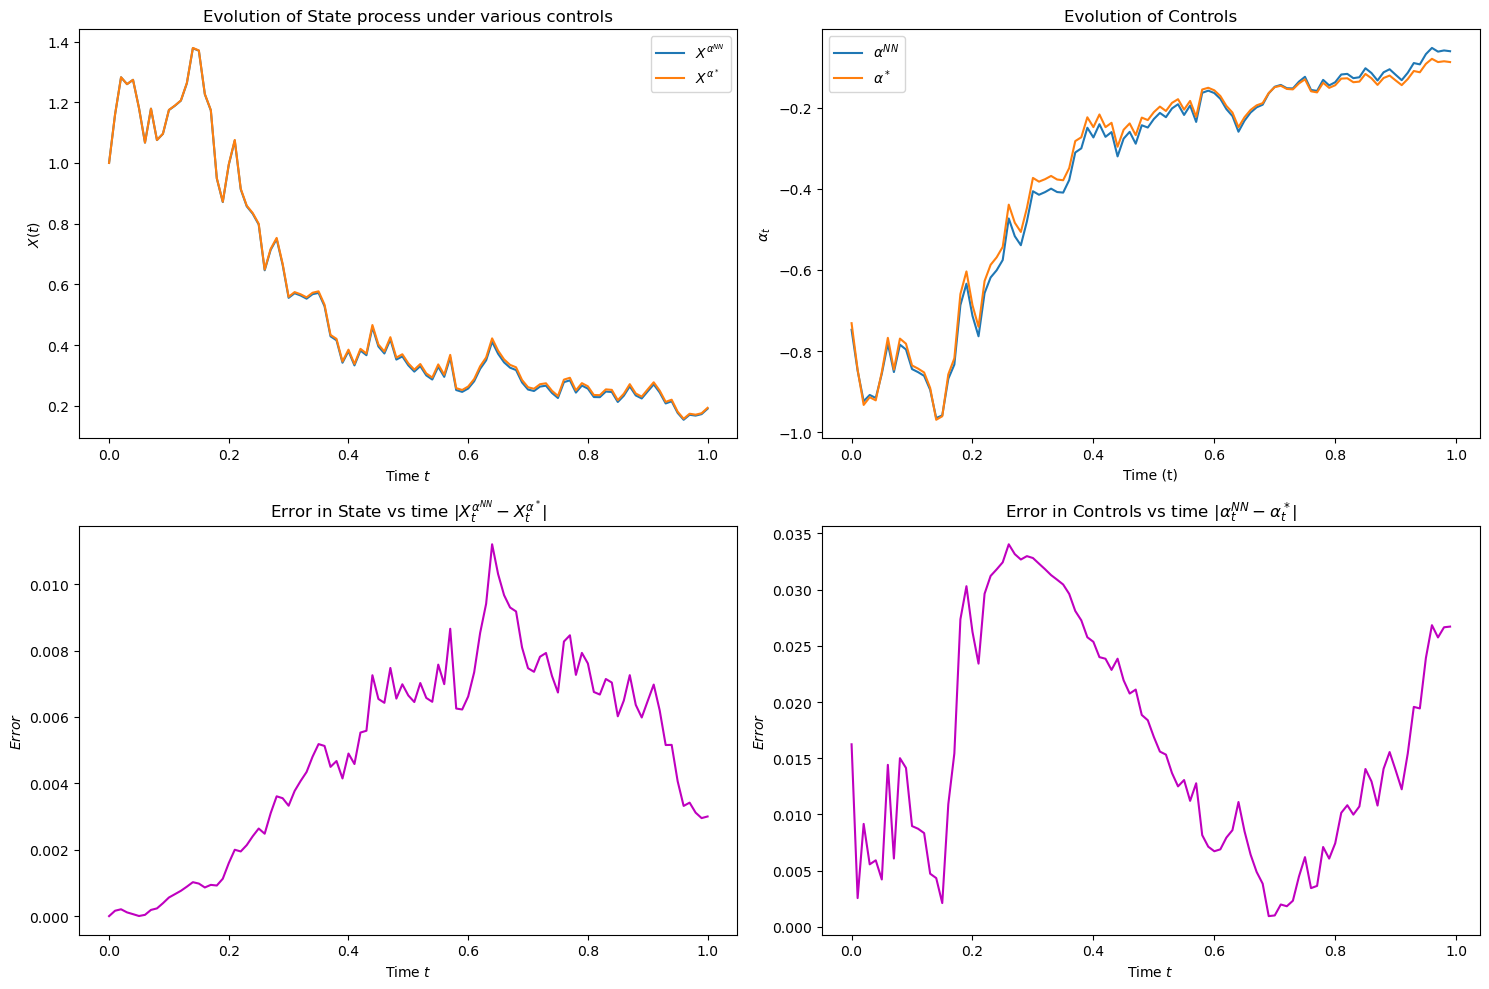

In [10]:
import matplotlib.pyplot as plt

with torch.no_grad():
    seed = 10
    
    t = np.linspace(0,T,N_steps+1)
    
    X = X.tolist()
    X_tens = torch.Tensor(N_steps,N_sim,1)
    torch.stack(X,out=X_tens)
    X_tens.squeeze()
    X_plt = X_tens.numpy()
    
    X_tr = X_tr.tolist()
    X_tr_tens = torch.Tensor(N_steps,N_sim,1)
    torch.stack(X_tr,out=X_tr_tens)
    X_tr_tens.squeeze()
    X_tr_plt = X_tr_tens.numpy()
    
    α = α.tolist()
    α_tens = torch.Tensor(N_steps,N_sim,1)
    torch.stack(α,out=α_tens)
    α_tens.squeeze()
    α_plt = α_tens.numpy()
    plt.figure(2)
    
    α_tr = α_tr.tolist()
    α_tr_tens = torch.Tensor(N_steps,N_sim,1)
    torch.stack(α_tr,out=α_tr_tens)
    α_tr_tens.squeeze()
    α_tr_plt = α_tr_tens.numpy()

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs = axs.flatten()

    axs[0].plot(t, X_plt[:,seed], t, X_tr_plt[:,seed])
    axs[0].set_xlabel(r'Time $t$')
    axs[0].set_ylabel(r'$X(t)$')
    axs[0].set_title("Evolution of State process under various controls")
    axs[0].legend([ r'$X^{\alpha^{NN}}$',r'$X^{\alpha^*}$'])

    axs[1].plot(t[0:-1], α_plt[:,seed], t[0:-1], α_tr_plt[:,seed])
    axs[1].set_xlabel("Time (t)")
    axs[1].set_ylabel(r'$\alpha_t$')
    axs[1].set_title("Evolution of Controls")
    axs[1].legend([r'$α^{NN}$',r'$\alpha^*$'])

    axs[2].plot(t,np.abs(X_plt[:,seed] - X_tr_plt[:,seed]),'m')
    axs[2].set_xlabel(r'Time $t$')
    axs[2].set_ylabel(r'$Error$')
    axs[2].set_title(r'Error in State vs time $|X^{\alpha^{NN}}_t - X^{\alpha^*}_t| $')

    axs[3].plot(t[0:-1],np.abs(α_plt[:,seed] - α_tr_plt[:,seed]),'m')
    axs[3].set_xlabel(r'Time $t$')
    axs[3].set_ylabel(r'$Error$')
    axs[3].set_title(r'Error in Controls vs time $|\alpha^{NN}_t - \alpha^*_t |$')

    plt.tight_layout()

In [11]:
J #empirical loss under NN control

tensor(0.7050)

In [12]:
J_tr #empirical loss under true control

tensor(0.7024)